In [10]:
# 이미지식별 머신을 이용한 데이터 처리 - 달 암석 이미지식별

# 환경설정

import matplotlib.pyplot as plt

import numpy as np

import torch
from torch import nn, optim

import torchvision
from torchvision import datasets, transforms, models

from PIL import Image

%matplotlib inline
%config InlineBackend.figure_format = 'retina'



In [11]:
# 기본 변수 설정 : 데이터 디렉토리와 검증 데이터 분할 비율 설정, 변환 방법 설정

data_dir = './data'
valid_size = 0.2

t_transforms = transforms.Compose([
               transforms.RandomResizedCrop(224),
             transforms.Resize(224),
              transforms.ToTensor()])

# 이미지 사이즈를 224로 조정하고, 텐서로 변환합니다. 텐서로 변환한다는 의미는 이미지의 픽셀값을 0~1 사이의 값으로 정규화한다는 의미입니다.

t_transforms = transforms.Compose([
                transforms.RandomResizedCrop(224),
                transforms.Resize(224),
                transforms.ToTensor()])
print(t_transforms)

Compose(
    RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
    Resize(size=224, interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
)


In [12]:
## 데이터세트 폴더 등 지정

# datasets.ImageFolder를 사용해서 학습 데이터(train_data)와 테스트 데이터(test_data)를 만든다.
# make train_data and test_data using datasets.ImageFolder
train_data = datasets.ImageFolder(data_dir, transform=t_transforms)
test_data = datasets.ImageFolder(data_dir, transform=t_transforms)

# 학습 데이터의 형식을 확인한다.
print(train_data)

# 학습 데이터와 테스트 데이터의 길이를 확인한다.
print(len(train_data), len(test_data))



Dataset ImageFolder
    Number of datapoints: 155
    Root location: ./data
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
               Resize(size=224, interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )
155 155


In [13]:
## 데이터세트를 찾기 위해 인덱스를 랜덤하게 섞기

# train_data 사이즈만큼의 정수값을 갖는 인덱스 리스트(indices)를 만들고 확인한다.
num_train = len(train_data)
indices = list(range(num_train))
print(indices)

# 인덱스 리스트를 랜덤하게 섞고 확인한다.
np.random.shuffle(indices)
print(indices)



[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154]
[35, 19, 138, 139, 114, 142, 61, 7, 143, 34, 154, 151, 96, 91, 65, 92, 127, 69, 48, 32, 120, 150, 41, 148, 87, 14, 68, 135, 149, 18, 73, 116, 31, 51, 130, 46, 29, 60, 15, 147, 72, 63, 5, 56, 121, 119, 3, 107, 25, 129, 66, 44, 152, 26, 57, 153, 99, 102, 54, 103, 74, 146, 36, 55, 145, 126, 52, 88, 78, 112, 70, 93, 140, 100, 24, 38, 89

In [14]:
# 분할 비율에 해당하는 인덱스의 개수를 계산한다.

split = int(np.floor(num_train * valid_size))
print(split)

### split을 나눈 이유

# 데이터셋을 학습용(train)과 검증용(test)으로 나누기 위해 사용하는 "경계 인덱스"입니다.
# 예를 들어, 전체 데이터의 20%를 검증용으로 쓰고 싶으면
# split = int(np.floor(num_train * valid_size))
# 이렇게 계산해서, 앞부분(split까지)은 검증용, 뒷부분은 학습용으로 나눕니다.



31


In [15]:
# 만든 split 을 기준으로 학습데이터 인덱스 리스트와 테스트용 인덱스 리스트로 나눈다.

train_idx, test_idx = indices[split:], indices[:split]

print(train_idx)
print(test_idx)

[116, 31, 51, 130, 46, 29, 60, 15, 147, 72, 63, 5, 56, 121, 119, 3, 107, 25, 129, 66, 44, 152, 26, 57, 153, 99, 102, 54, 103, 74, 146, 36, 55, 145, 126, 52, 88, 78, 112, 70, 93, 140, 100, 24, 38, 89, 6, 23, 1, 33, 62, 45, 94, 82, 76, 27, 39, 80, 4, 71, 137, 113, 136, 81, 75, 2, 0, 43, 86, 101, 109, 144, 11, 97, 28, 132, 133, 59, 47, 110, 22, 40, 8, 106, 124, 108, 17, 105, 131, 84, 134, 117, 90, 111, 115, 64, 118, 98, 67, 123, 128, 42, 77, 95, 21, 122, 37, 125, 12, 20, 16, 30, 141, 13, 85, 50, 104, 58, 79, 9, 83, 10, 53, 49]
[35, 19, 138, 139, 114, 142, 61, 7, 143, 34, 154, 151, 96, 91, 65, 92, 127, 69, 48, 32, 120, 150, 41, 148, 87, 14, 68, 135, 149, 18, 73]


In [16]:
# 데이터 로딩을 위한 loader 를 만든다


## loader를 만들기위해  먼저, 샘플링 방식을 지정한다.
from torch.utils.data.sampler import SubsetRandomSampler
train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

## lodader를 만든다, (이때, 샘플러와 배치 사이즈를 지정한다.)
trainloader = torch.utils.data.DataLoader(train_data, sampler=train_sampler, batch_size=16)
testloader = torch.utils.data.DataLoader(test_data, sampler=test_sampler, batch_size=16)

print(trainloader.dataset.classes)
print(testloader.dataset.classes)

## 출력결과는 해당 위치가 되는 클래스 이름이 출력된다.

['Basalt', 'Highland']
['Basalt', 'Highland']


In [17]:
# 코드를 묶어서 load split train test() 함수를 만든다\
# => 여러 단계의 코드를 한 번에 실행할 수 있도록 입력값(데이터 폴더, 검증 비율 등)을 받아 학습용/검증용 DataLoader를 한 번에 만들어 반환하는 재사용 가능한 함수로 만든다는 의미입니다
# 여러 단계의 코드를 한 번에 실행할 수 있도록입력값(데이터 폴더, 검증 비율 등)을 받아학습용/검증용 DataLoader를 한 번에 만들어 반환하는
# 재사용 가능한 함수로 만든다는 의미
# 지금까지 여러 셀에 나눠서 작성한 데이터 불러오기, 섞기, 분할, DataLoader 생성 과정을
# **하나의 함수(load_split_train_test)**로 정리해서 필요할 때마다 간단하게 함수 호출만으로 같은 작업을 반복작업 가능

def load_split_train_test(data_dir, valid_size) :
    # datadir은 데이터세트폴더 , valid size는 분할비
    t_transforms = transforms.Compose([
                transforms.RandomResizedCrop(224),
                transforms.Resize(224),
                transforms.ToTensor()
    ])
    ## t_transforms에서 사용된 ToTensor()는이미지 데이터를 파이토치에서 사용할 수 있는 텐서(tensor) 형태로 변환해 주는 함수
    ## 원래 이미지는 PIL 이미지나 넘파이 배열 형태인데 ToTensor()를 사용하면 픽셀값(0<del>255)을 0</del>1 사이의 값으로 정규화하고 파이토치 텐서(다차원 배열)로 바꿔준다.
    
    train_data = datasets.ImageFolder(data_dir, transform=t_transforms)
    test_data = datasets.ImageFolder(data_dir, transform=t_transforms)
    num_train = len(train_data)
    indices = list(range(num_train))

    np.random.shuffle(indices)
    split = int(np.floor(num_train * valid_size))
    train_idx, test_idx = indices[split:], indices[:split]
    from torch.utils.data.sampler import SubsetRandomSampler

    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)

    trainloader = torch.utils.data.DataLoader(train_data, sampler=train_sampler, batch_size=16)
    testloader = torch.utils.data.DataLoader(test_data, sampler=test_sampler, batch_size=16)

    return trainloader, testloader

trainloader, testloader = load_split_train_test(data_dir, 0.2)

print(trainloader.dataset.classes)
print(testloader.dataset.classes)


['Basalt', 'Highland']
['Basalt', 'Highland']


In [18]:
#  이미지/레이블 샘플 데이터 가져오기 

## 임의데이터 로딩후 이미지와 레이블을 반환한다. -> get_random_images() 라는 함수를 직접 만든다.

def get_random_images(num) :

    data = datasets.ImageFolder(data_dir, transform=t_transforms)
    indices = list(range(len(data)))
    np.random.shuffle(indices)
    idx = indices[:num]

    from torch.utils.data.sampler import SubsetRandomSampler
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(data, sampler=sampler, batch_size=num)
    # loader에서 데이터를 한 개씩 꺼내 주는 iterator를 생성한다.
    dataiter = iter(loader)
    images, labels = dataiter.next()

    return images, labels




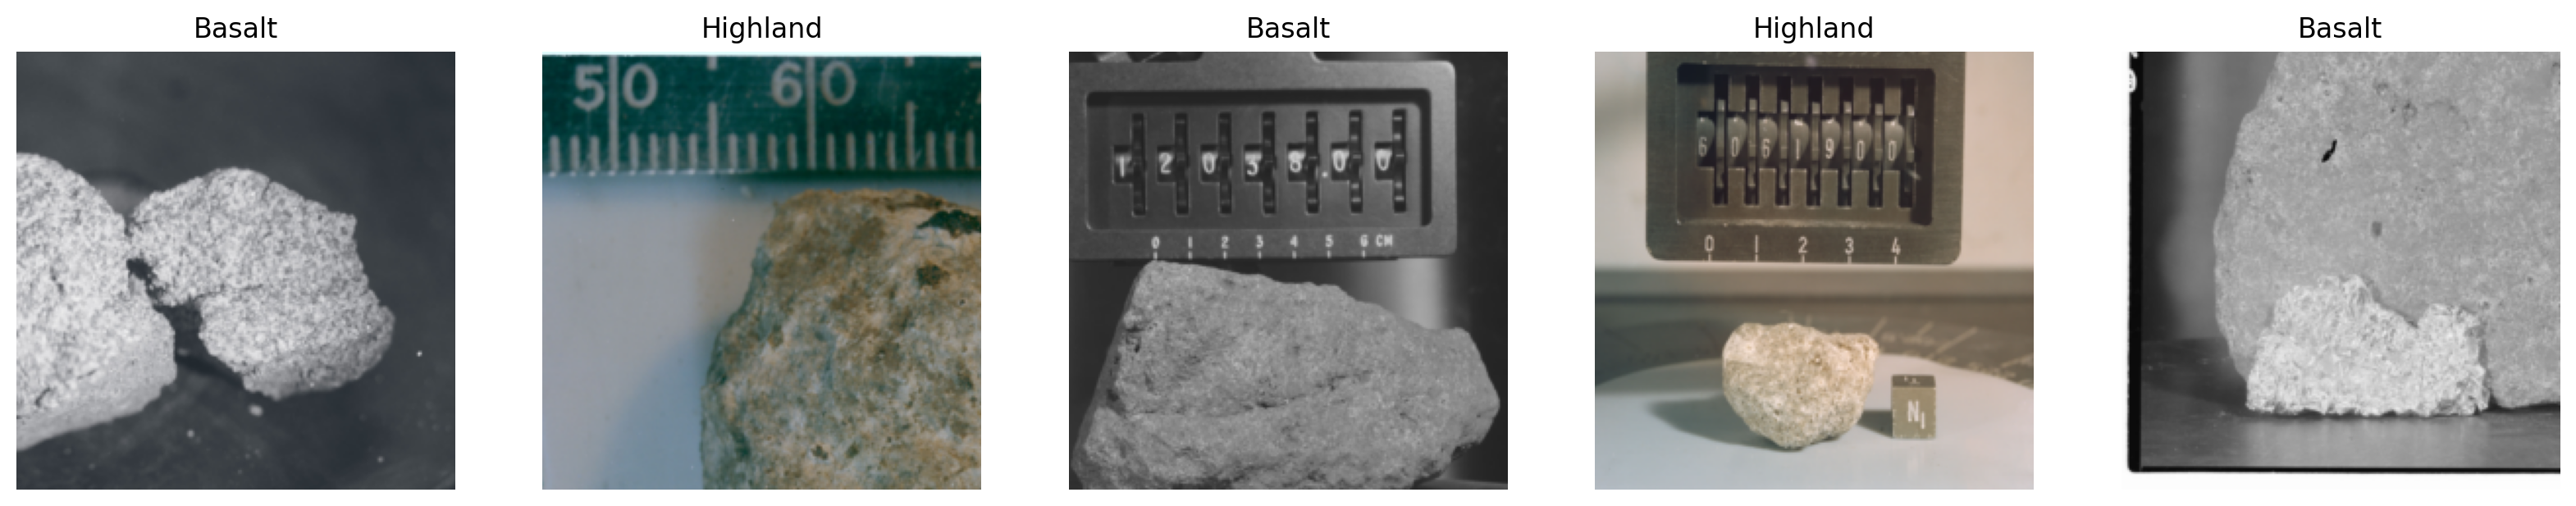

In [25]:
## 이미지 산출 ( 랜덤 선택, 이미지 형식과 크기 설정, class 리스트 얻어 표시)

# 5개의 이미지와 레이블을 랜덤하게 가져온다.
images, labels = get_random_images(5)

# 픽셀 배열을 PIL 형식의 이미지로 변환하고 이미지 크기를 지정한다.
to_pil = transforms.ToPILImage()
fig = plt.figure(figsize=(20, 20))

# 학습 데이터의 class 리스트를 얻는다.
classes = trainloader.dataset.classes

# 이미지를 표시하기 위한 설정을 한다.
for ii in range(len(images)) :
    image = to_pil(images[ii])
    sub = fig.add_subplot(1, len(images), ii+1)
    index = labels[ii].item()
    sub.set_title(classes[index])
    plt.axis('off')
    plt.imshow(image)
# 주피터 노트북에 이미지를 표시한다.
plt.show()

In [22]:
# ResNET50 모델을 가져와 FCL을 수정한다

## compute device를 정하고 확인한다. (GPU or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [24]:
# resnet50 모델을 pretrained=True로 설정한다.
# resnet 모델은 이미 제공되어 있다.
# 암석 이미지 식별 실습을 위해 Python의 PyTorch를 이용함.
#PyTorch의 라이브러리 중 하나인 TorchVision에서 ResNet50 등 사전 학습된 이미지 인식 모델 제공.
# TorchVision은 dataset, models, transforms 등 다양한 하위 라이브러리를 제공함.
model = models.resnet50(pretrained=True)

print(model)

/workspaces/boolsajoAI/.venv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/workspaces/boolsajoAI/.venv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [27]:
# fCL(Fully Connected Layer, 완전 연결 계층)을 수정한다 : 완전 연결 계층을 수정 -> resnet50의 마지막 출력층 부분을 내가 분류하고 싶은 클래스의 수에 맞게 수정
# ----> 기본은 1000개 설정되어있다.

# 모든 신경망 구축 : 전이학습을 위해 모델의 가중치를 freeze 한다.
for param in model.parameters():
    # freeze model weights
    param.requires_grad = False
    
# 뉴런들을 연결하여 신경망을 생성한다.
model.fc = nn.Sequential(nn.Linear(2048, 512),
                            nn.ReLU(),
                            nn.Dropout(0.2),
                            nn.Linear(512, 2),
                            nn.LogSoftmax(dim=1))
# q: explain the above code
# a: 2048개의 입력을 받아 512개의 출력을 내고, ReLU 함수를 거쳐 0.2의 확률로 Dropout을 적용한다.
# 512개의 입력을 받아 2개의 출력을 내고, LogSoftmax 함수를 거쳐 1차원으로 변환한다.
# 1차원으로 변환된 출력을 갖는 신경망을 생성한다.

# 손실함수를 Cross entropy loss 함수로 지정한다.
criterion = nn.NLLLoss()
# why
# optimizer를 Adam으로 지정한다.
# what is Adam
#
optimizer = optim.Adam(model.fc.parameters(), lr=0.003)
# 신경망을 compute device로 보낸다.
model.to(device)
# 종료 여부를 출력한다.

print(model.fc)


done!
Sequential(
  (0): Linear(in_features=2048, out_features=512, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=512, out_features=2, bias=True)
  (4): LogSoftmax(dim=1)
)


Training step  1
Training step  2
Training step  3
Training step  4
Training step  5
Epoch 1/11:  Train loss: 0.217..  Test loss: 1.354..  Test accuracy: 0.294

Training step  6
Training step  7
Training step  8
Training step  9
Training step  10
Epoch 2/11:  Train loss: 0.107..  Test loss: 0.894..  Test accuracy: 0.483

Training step  11
Training step  12
Training step  13
Training step  14
Training step  15
Epoch 3/11:  Train loss: 0.184..  Test loss: 0.639..  Test accuracy: 0.677

Training step  16
Training step  17
Training step  18
Training step  19
Training step  20
Epoch 4/11:  Train loss: 0.208..  Test loss: 0.363..  Test accuracy: 0.871

Training step  21
Training step  22
Training step  23
Training step  24
Training step  25
Epoch 5/11:  Train loss: 0.160..  Test loss: 0.255..  Test accuracy: 0.869

Training step  26
Training step  27
Training step  28
Training step  29
Training step  30
Epoch 6/11:  Train loss: 0.158..  Test loss: 0.254..  Test accuracy: 0.933

Training step

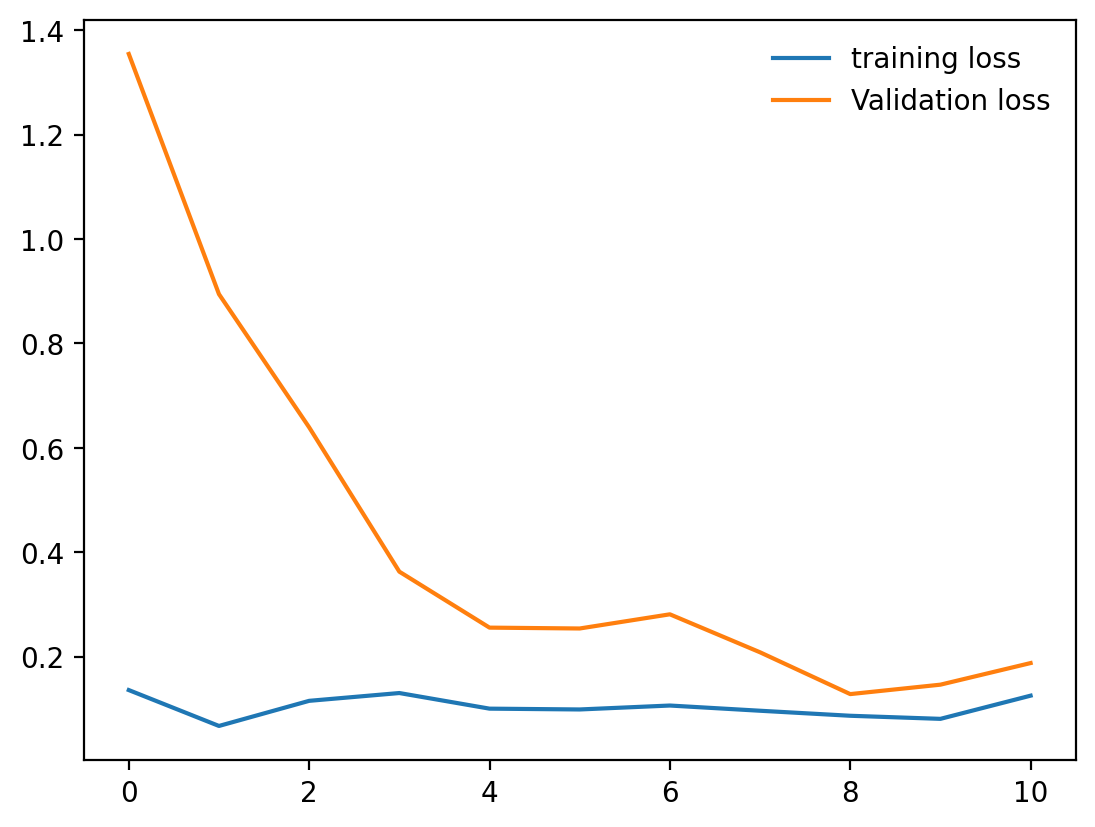

In [36]:
# 학습을 위한 변수 설정값 지정 후 학습 및 검증, 평가

# 에폭 및 출력 간격을 설정한다.
epochs = 11
print_every = 5
# 손실 변수들을 초기화 한다.
running_loss = 0
train_losses, test_losses = [], []
# 현재의 학습 단계를 표현하는 steps 변수를 0으로 초기화 한다.
steps = 0

# 설정한 회수만큼 학습 후 테스트 및 평가해 본다.
for epoch in range(epochs) :
    # 에폭을 count 한다.
    epoch += 1
    # trainloader로부터 모든 이미지와 레이블을 로드한다.
    for inputs, labels in trainloader:
        # 학습 단계를 count 하고 출력한다.
        steps += 1
        print('Training step ', steps)
        # 입력 데이터(이미지, 레이블)를 device로 보낸다.
        inputs, labels = inputs.to(device), labels.to(device)
        # 기존에 학습된 gradient 값을 초기화 한다.(이전에 학습한 값이 영향을 주지 않도록 함)
        optimizer.zero_grad()
        # 입력 데이터로 순전파를 수행하고 로그 확률을 얻는다.
        logps = model.forward(inputs)
        # 손실(loss) 값들을 계산한다.
        loss = criterion(logps, labels)
        # 손실값을 이용하여 gradient를 update한다.
        loss.backward()
        # gradient를 이용하여 설정된 optimizer로 파라미터를 update한다.
        optimizer.step()
        # 손실값을 누적/계산한다.
        running_loss += loss.item()
        # 학습 단계 5회마다 모델을 테스트/평가 한다.
        if steps % print_every == 0:
            # 손실과 정확도 변수를 초기화 한다.
            test_loss = 0
            accuracy = 0
            # 모델 평가 모드로 전환한다.
            model.eval()
            # 모델 평가 시 gradient를 계산하지 않도록 한다.
            with torch.no_grad():
                # testloader로부터 모든 이미지와 레이블을 로드한다.
                for inputs, labels in testloader:
                    # 입력 데이터(이미지, 레이블)를 device로 보낸다.
                    inputs, labels = inputs.to(device), labels.to(device)
                    # 입력 데이터로 순전파를 수행하고 로그 확률을 얻는다.
                    logps = model.forward(inputs)
                    # 손실(loss) 값들을 계산한다.
                    batch_loss = criterion(logps, labels)
                    # 손실값을 누적시킨다.
                    test_loss += batch_loss.item()
                    # 로그 확률로부터 진짜 확률값을 계산한다.
                    ps = torch.exp(logps)
                    # 가장 큰 확률값과 class를 얻는다. (topk : k번째로 큰 값)
                    top_p, top_class = ps.topk(1, dim=1)
                    # 레이블들을 top_class와 동일한 형태로 바꾼 후 같은 값들을 얻는다.
                    equals = top_class == labels.view(*top_class.shape)
                    # equals를 float 텐서로 바꾼 후 평균 정확도를 누적/계산한다.
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            # 학습 손실값과 테스트 손실값을 추가한다.
            train_losses.append(running_loss/len(trainloader))
            test_losses.append(test_loss/len(testloader))
            # 학습 손실값, 테스트 손실값, 테스트 정확도를 출력한다.
            print("Epoch {}/{}: ".format(epoch, epochs),
                  "Train loss: {:.3f}.. ".format(running_loss/print_every),
                  "Test loss: {:.3f}.. ".format(test_loss/len(testloader)),
                  "Test accuracy: {:.3f}\n".format(accuracy/len(testloader))) 
            # running_loss 값을 초기화 한다.
            running_loss = 0
            # 모델 학습 모드로 전환한다.
            model.train()
            break

        %matplotlib inline
%config InlineBackend.figure_format='retina'

plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

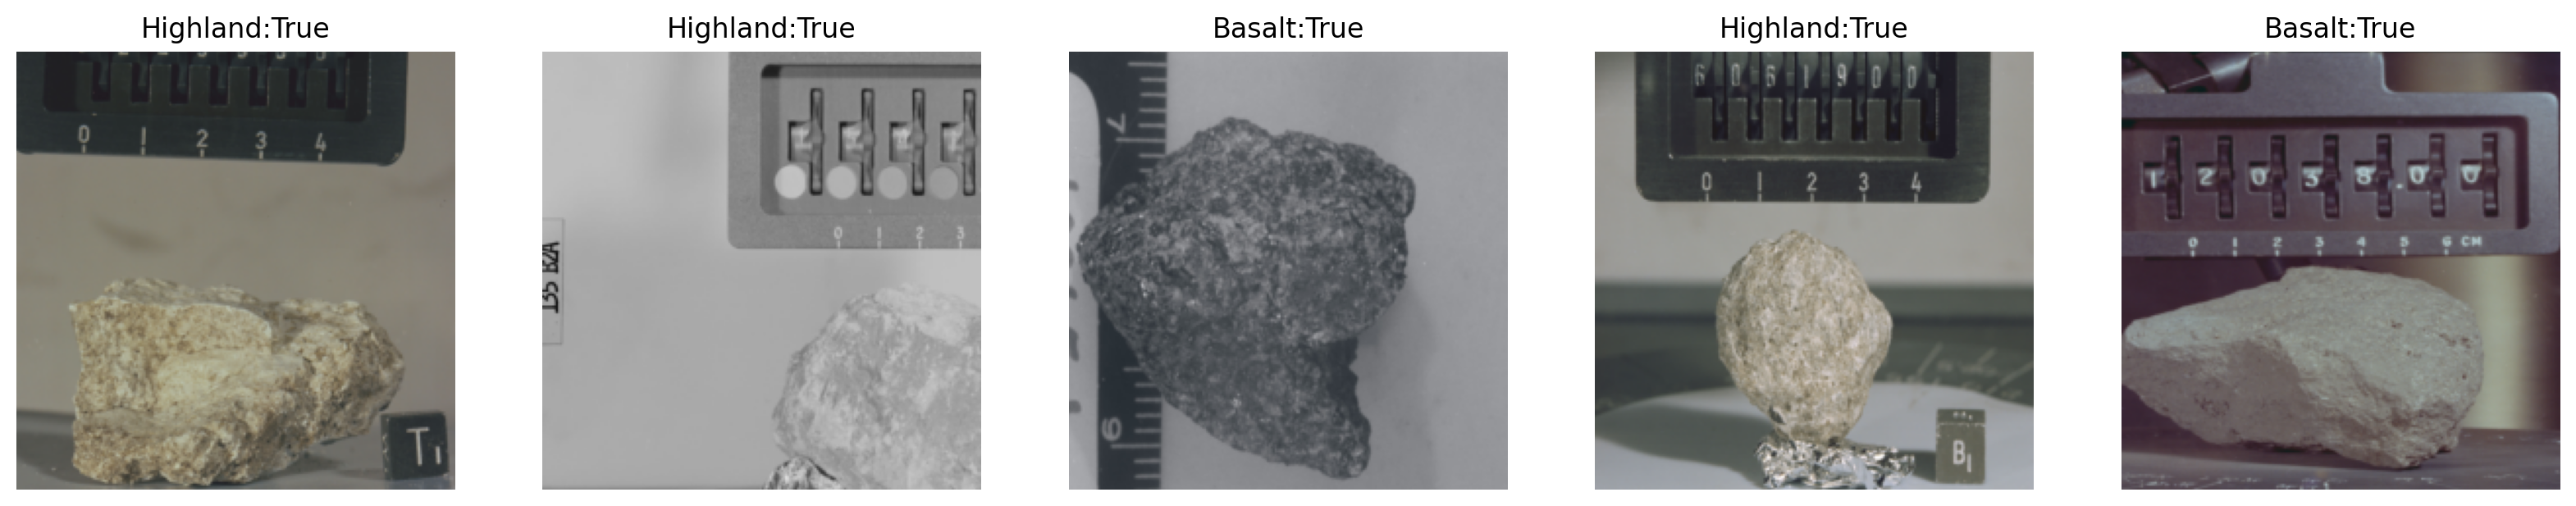

In [32]:
# 학습된 모델 저장 및 사후 활용 준비

# 학습된 모델 저장

torch.save(model, 'moonrockmodel.pth')

# 저장한 모델을 불러온다.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = torch.load('moonrockmodel.pth')

print(model)

# 이미지 예측 함수 만들기

def predict_image(image):
    image_tensor = t_transforms(image).float()
    input = image_tensor.unsqueeze_(0)
    input = input.to(device)
    output = model(input)
    index = output.data.numpy().argmax()

    return index

# 모델 평가 모드로 전환한다.
model.eval()


# 5개의 이미지를 랜덤하게 가져온 후 PIL 형식 변환, 표시할 이미지 크기를 설정한다.
to_pil = transforms.ToPILImage()
images, labels = get_random_images(5)
fig = plt.figure(figsize=(20, 20))
# 데이터의 class 목록을 얻는다.
classes = trainloader.dataset.classes

# 5개의 이미지에 대해 loop를 수행한다.
for ii in range(len(images)):
    # 각 이미지에 대해 class를 예측한다.
    image = to_pil(images[ii])
    index = predict_image(image)
    # 이미지 아래에 class를 표시하도록 설정한다.
    sub = fig.add_subplot(1, len(images), ii+1)
    res = labels[ii].item() == index
    sub.set_title(classes[index] + ':' + str(res))
    plt.axis('off')
    plt.imshow(image)
# 레이블이 추가된 이미지를 보여준다.
plt.show()

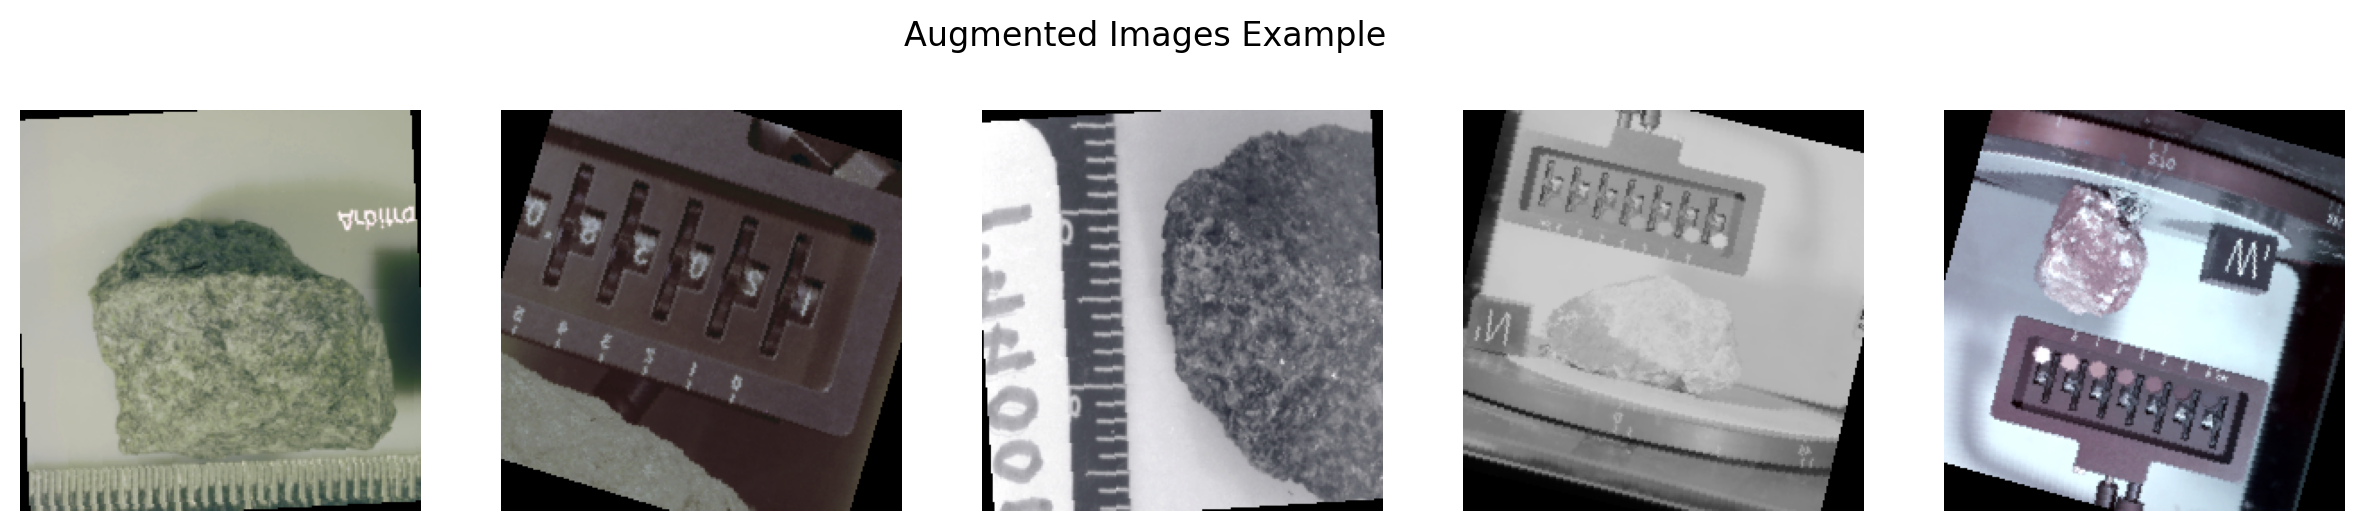

Training step  1
Training step  2
Training step  3
Training step  4
Training step  5
Epoch 1/11:  Train loss: 3.257..  Test loss: 3.669..  Test accuracy: 0.646

Training step  6
Training step  7
Training step  8
Training step  9
Training step  10
Epoch 2/11:  Train loss: 2.935..  Test loss: 1.574..  Test accuracy: 0.356

Training step  11
Training step  12
Training step  13
Training step  14
Training step  15
Epoch 3/11:  Train loss: 1.250..  Test loss: 0.502..  Test accuracy: 0.740

Training step  16
Training step  17
Training step  18
Training step  19
Training step  20
Epoch 4/11:  Train loss: 0.917..  Test loss: 0.626..  Test accuracy: 0.550

Training step  21
Training step  22
Training step  23
Training step  24
Training step  25
Epoch 5/11:  Train loss: 0.623..  Test loss: 0.530..  Test accuracy: 0.804

Training step  26
Training step  27
Training step  28
Training step  29
Training step  30
Epoch 6/11:  Train loss: 0.486..  Test loss: 0.458..  Test accuracy: 0.838

Training step

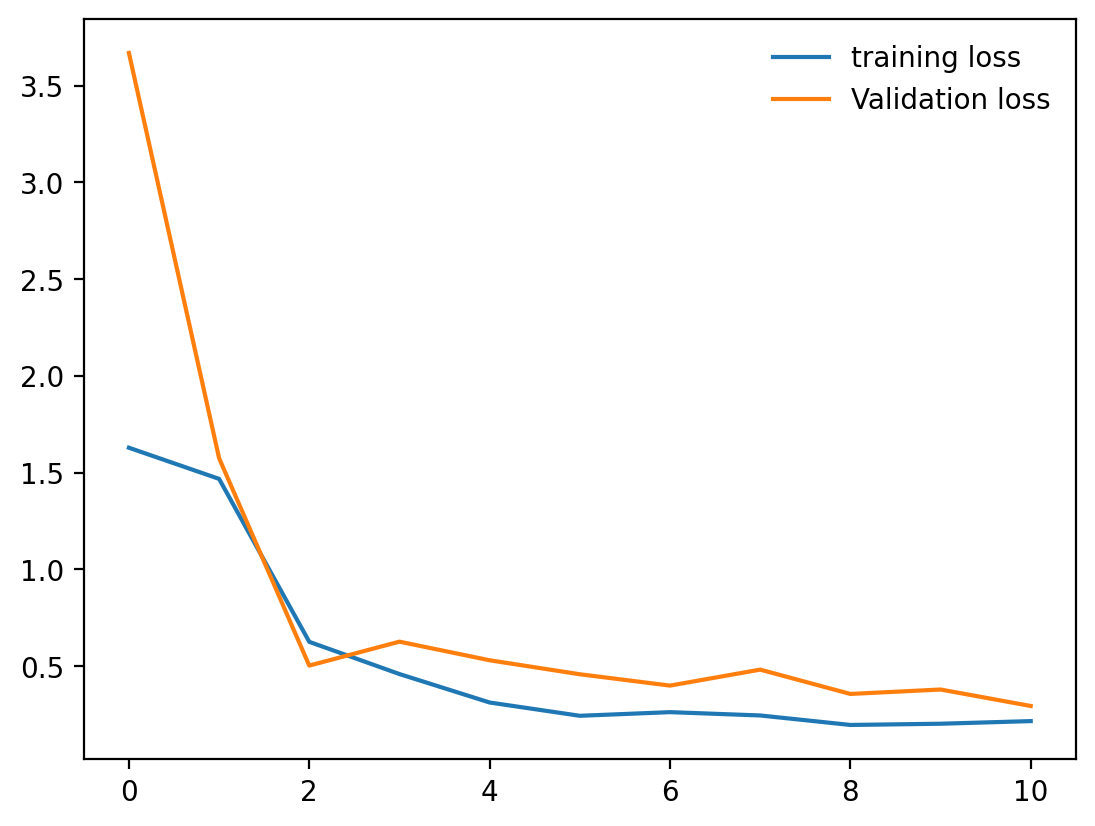

In [17]:
# 재현성 확보하기 (랜덤시드 설정)
# 머신이 돌아갈때의 초기값 같은 개념 : 시드


# 다양한 방법으로 데이터 전처리 및 증강을 시도해보고 loss 와 accuracy 비교해보기


# 머신러닝용 이미지 전처리 및 증강(Augmentation) 예시
from torchvision import transforms
import random
import numpy as np
from torchvision import datasets, models, transforms
import torch
import matplotlib.pyplot as plt
from torch import nn, optim

model = models.resnet50(pretrained=True)

# 모든 신경망 구축 : 전이학습을 위해 모델의 가중치를 freeze 한다.
for param in model.parameters():
    # freeze model weights
    param.requires_grad = False
    
# 뉴런들을 연결하여 신경망을 생성한다.
model.fc = nn.Sequential(nn.Linear(2048, 512),
                            nn.ReLU(),
                            nn.Dropout(0.2),
                            nn.Linear(512, 2),
                            nn.LogSoftmax(dim=1))
 

data_dir = "./data"
# 에폭 및 출력 간격을 설정한다.
epochs = 11
print_every = 5
# 손실 변수들을 초기화 한다.
running_loss = 0
train_losses, test_losses = [], []
# 현재의 학습 단계를 표현하는 steps 변수를 0으로 초기화 한다.
steps = 0
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optimizer = optim.Adam(model.fc.parameters(), lr=0.003)
criterion = nn.NLLLoss()

def load_split_train_test(data_dir, valid_size) :
    # datadir은 데이터세트폴더 , valid size는 분할비
    t_transforms = transforms.Compose([
                transforms.RandomResizedCrop(224),
                transforms.Resize(224),
                transforms.ToTensor()
    ])
    ## t_transforms에서 사용된 ToTensor()는이미지 데이터를 파이토치에서 사용할 수 있는 텐서(tensor) 형태로 변환해 주는 함수
    ## 원래 이미지는 PIL 이미지나 넘파이 배열 형태인데 ToTensor()를 사용하면 픽셀값(0<del>255)을 0</del>1 사이의 값으로 정규화하고 파이토치 텐서(다차원 배열)로 바꿔준다.
    
    train_data = datasets.ImageFolder(data_dir, transform=t_transforms)
    test_data = datasets.ImageFolder(data_dir, transform=t_transforms)
    num_train = len(train_data)
    indices = list(range(num_train))

    np.random.shuffle(indices)
    split = int(np.floor(num_train * valid_size))
    train_idx, test_idx = indices[split:], indices[:split]
    from torch.utils.data.sampler import SubsetRandomSampler

    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)

    trainloader = torch.utils.data.DataLoader(train_data, sampler=train_sampler, batch_size=16)
    testloader = torch.utils.data.DataLoader(test_data, sampler=test_sampler, batch_size=16)

    return trainloader, testloader

trainloader, testloader = load_split_train_test(data_dir, 0.2)




# 재현성 확보: 랜덤시드 고정
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)  # 시드 고정

# 다양한 이미지 증강 기법 적용 예시
aug_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # ImageNet 통계로 정규화
])

# 증강된 데이터셋 생성 예시
aug_train_data = datasets.ImageFolder(data_dir, transform=aug_transforms)
aug_trainloader = torch.utils.data.DataLoader(aug_train_data, batch_size=16, shuffle=True)

# 증강된 이미지 시각화 예시
def show_augmented_images(loader, n=5):
    dataiter = iter(loader)
    images, labels = dataiter.next()
    to_pil = transforms.ToPILImage()
    fig = plt.figure(figsize=(15, 3))
    for i in range(n):
        img = to_pil(images[i].cpu())
        ax = fig.add_subplot(1, n, i+1)
        ax.imshow(img)
        ax.axis('off')
    plt.suptitle('Augmented Images Example')
    plt.show()

show_augmented_images(aug_trainloader, n=5)




# 설정한 회수만큼 학습 후 테스트 및 평가해 본다.
for epoch in range(epochs) :
    # 에폭을 count 한다.
    epoch += 1
    # trainloader로부터 모든 이미지와 레이블을 로드한다.
    for inputs, labels in aug_trainloader:
        # 학습 단계를 count 하고 출력한다.
        steps += 1
        print('Training step ', steps)
        # 입력 데이터(이미지, 레이블)를 device로 보낸다.
        inputs, labels = inputs.to(device), labels.to(device)
        # 기존에 학습된 gradient 값을 초기화 한다.(이전에 학습한 값이 영향을 주지 않도록 함)
        optimizer.zero_grad()
        # 입력 데이터로 순전파를 수행하고 로그 확률을 얻는다.
        logps = model.forward(inputs)
        # 손실(loss) 값들을 계산한다.
        loss = criterion(logps, labels)
        # 손실값을 이용하여 gradient를 update한다.
        loss.backward()
        # gradient를 이용하여 설정된 optimizer로 파라미터를 update한다.
        optimizer.step()
        # 손실값을 누적/계산한다.
        running_loss += loss.item()
        # 학습 단계 5회마다 모델을 테스트/평가 한다.
        if steps % print_every == 0:
            # 손실과 정확도 변수를 초기화 한다.
            test_loss = 0
            accuracy = 0
            # 모델 평가 모드로 전환한다.
            model.eval()
            # 모델 평가 시 gradient를 계산하지 않도록 한다.
            with torch.no_grad():
                # testloader로부터 모든 이미지와 레이블을 로드한다.
                for inputs, labels in testloader:
                    # 입력 데이터(이미지, 레이블)를 device로 보낸다.
                    inputs, labels = inputs.to(device), labels.to(device)
                    # 입력 데이터로 순전파를 수행하고 로그 확률을 얻는다.
                    logps = model.forward(inputs)
                    # 손실(loss) 값들을 계산한다.
                    batch_loss = criterion(logps, labels)
                    # 손실값을 누적시킨다.
                    test_loss += batch_loss.item()
                    # 로그 확률로부터 진짜 확률값을 계산한다.
                    ps = torch.exp(logps)
                    # 가장 큰 확률값과 class를 얻는다. (topk : k번째로 큰 값)
                    top_p, top_class = ps.topk(1, dim=1)
                    # 레이블들을 top_class와 동일한 형태로 바꾼 후 같은 값들을 얻는다.
                    equals = top_class == labels.view(*top_class.shape)
                    # equals를 float 텐서로 바꾼 후 평균 정확도를 누적/계산한다.
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                    
            # 학습 손실값과 테스트 손실값을 추가한다.
            train_losses.append(running_loss/len(aug_trainloader))
            test_losses.append(test_loss/len(testloader))
            # 학습 손실값, 테스트 손실값, 테스트 정확도를 출력한다.
            print("Epoch {}/{}: ".format(epoch, epochs),
                  "Train loss: {:.3f}.. ".format(running_loss/print_every),
                  "Test loss: {:.3f}.. ".format(test_loss/len(testloader)),
                  "Test accuracy: {:.3f}\n".format(accuracy/len(testloader))) 
            # running_loss 값을 초기화 한다.
            running_loss = 0
            # 모델 학습 모드로 전환한다.
            model.train()
            break

        %matplotlib inline
%config InlineBackend.figure_format='retina'

plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)
